In [1]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./funlopt/funl_dynamics.jl")
include("./funlopt/funl_utils.jl")
include("./funlopt/funl_constraint.jl")
include("./trajopt/scaling.jl")

compute_scaling (generic function with 1 method)

In [2]:
# load nominal trajectory
using JLD2, FileIO
@load "./data/nominal_traj_unicycle_0324" my_dict
xnom = my_dict["x"]
unom = my_dict["u"]
tnom = my_dict["t"];
N = size(xnom,2) - 1
dtnom = zeros(N)
for i in 1:N
    dtnom[i] = tnom[i+1]-tnom[i]
end

In [3]:
ix = 3
iu = 2
iϕ = 2
iv = 2
iψ = iϕ*iv
iμ = iψ
@assert size(xnom,2) - 1 == N

In [4]:
Go = [1 2;1 2;0 0]
G = kron(Go,ones(1,iv))
Cv = [0 0 1;0 0 0] 
Dvu = [0 0;1 0]

2×2 Matrix{Int64}:
 0  0
 1  0

In [5]:
dynamics = Unicycle()
alpha = 0.7
DLMI = LinearDLMI(alpha,ix,iu)

LinearDLMI(0.7, 3, 2, 9, 6, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1])

In [6]:
function get_H_obs(rx,ry)
    return diagm([1/rx,1/ry])
end
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.5,0.5)
push!(c_list,c1)
push!(H_list,H1)
c2 = [4,3]
H2 = get_H_obs(0.5,0.5)
push!(c_list,c2)
push!(H_list,H2)

vmax = 2.0
vmin = 0.0
wmax = 2.0
wmin = -2.0
list_const = [InputConstraint([1;0],vmax),
    InputConstraint([-1;0],-vmin),
    InputConstraint([0; 1],wmax),
    InputConstraint([0; -1],-wmin),
    ObstacleAvoidance(H_list[1],c_list[1]),
    ObstacleAvoidance(H_list[2],c_list[2])
    ]

6-element Vector{FunnelConstraint}:
 InputConstraint([1, 0], 2.0)
 InputConstraint([-1, 0], -0.0)
 InputConstraint([0, 1], 2.0)
 InputConstraint([0, -1], 2.0)
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2])
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])

In [7]:
Qnom = zeros(ix,ix,N+1)
Ynom = zeros(iu,ix,N+1)
Znom = zeros(ix,ix,N+1);
Qini = diagm([0.08,0.08,0.06])
Qf = diagm([0.08,0.08,0.06])

3×3 Matrix{Float64}:
 0.08  0.0   0.0
 0.0   0.08  0.0
 0.0   0.0   0.06

In [8]:
xmin = [0;0;0];
xmax = [5;5;pi];
umin = [0;0];
umax = [vmax;wmax];
scaler = Scaling(xmin, xmax, umin, umax, tnom[end],0,0)

Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 5.0, 0.0, 0.0)

In [24]:
include("./funlopt/funl_synthesis.jl")

run (generic function with 1 method)

In [25]:
max_iter = 1;
w_funl = 1.0;
w_vc = 1e2;
w_tr::Float64 = 0.01
tol_vc = 1e-6;
tol_tr = 1e-4;
tol_dyn = 1e-1;
verbosity = true;

In [26]:
fs = FunnelSynthesis(N,max_iter,dynamics,DLMI,list_const,scaler,w_funl,w_vc,w_tr,tol_tr,tol_vc,tol_dyn,verbosity)

FunnelSynthesis(Unicycle(3, 2), LinearDLMI(0.7, 3, 2, 9, 6, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1]), FunnelConstraint[InputConstraint([1, 0], 2.0), InputConstraint([-1, 0], -0.0), InputConstraint([0, 1], 2.0), InputConstraint([0, -1], 2.0), ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2]), ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])], Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 5.0, 0.0, 0.0), FunnelSolution([0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; … ;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0;;; … ;;; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0

In [27]:
run(fs,Qnom,Ynom,Znom,Qini,Qf,xnom,unom,dtnom,"Mosek")

+--------------------------------------------------------------------------------------------------+
|                                   ..:: Penalized Trust Region ::..                               |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
| iter. |    cost    |    tof    |   funl    |   rate    |  param  | log(vc) | log(tr)  | log(dyn) |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
|1      |-2.32       |-1.000    |-2.354     |-1.000     |-1.000    |-Inf     | 0.6      |-7.2e+00   |


In [28]:
tprop,xprop,uprop = fs.solution.tprop,fs.solution.xprop,fs.solution.uprop
Qprop,Yprop = fs.solution.Qprop,fs.solution.Yprop

([5.170769674512177 -3.768421887880569 2.9240998789416075; -3.768421887880569 5.463223476601855 -3.850809109897669; 2.924099878941608 -3.8508091098976696 3.491330111063977;;; 5.2129492348424336 -3.7889571642431052 2.9761854049959267; -3.788957164243104 5.442649766777735 -3.8677990101078406; 2.9761854049958005 -3.867799010107208 3.4994346471368014;;; 5.294245074404704 -3.8149484942421097 3.0786735689161366; -3.814948494242106 5.366149069538887 -3.8857527009355497; 3.078673568915705 -3.8857527009335016 3.5193408353050692;;; … ;;; 0.1092401082315738 0.024203533939718042 -0.040990628353739574; 0.024203533940155595 0.06437300020342036 -0.06006184674986315; -0.040990628353979715 -0.060061846750066844 0.07342819641544772;;; 0.09284023735410053 0.01500841588386734 -0.016427535032137158; 0.01500841588453146 0.06045456430640867 -0.042427959487423325; -0.016427535032502875 -0.04242795948773091 0.050811478777275;;; 0.0773882399043082 0.007248344981193045 0.008371122370243208; 0.007248344982111301 

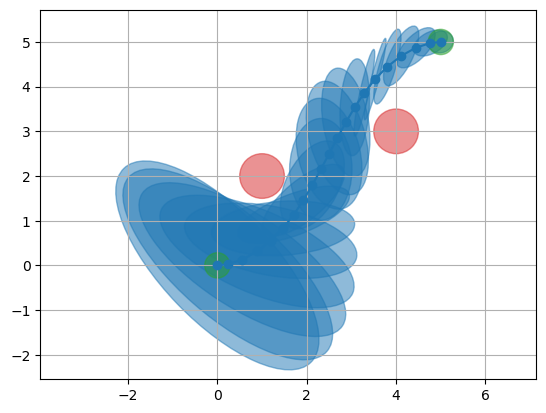

In [29]:
radius_Q,angle_Q = get_radius_angle_Ellipse2D(fs.solution.Q)
radius_Qi,angle_Qi = get_radius_angle_Ellipse2D(fs.solution.Qi)
radius_Qf,angle_Qf = get_radius_angle_Ellipse2D(fs.solution.Qf)

plt.figure()
ax = plt.subplot(111)
for (ce, H) in zip(c_list, H_list)
    rx = 1 / H[1, 1]  # Adjusted indexing for Julia (1-based indexing)
    ry = 1 / H[2, 2]  # Adjusted indexing for Julia
    circle1 = matplotlib[:patches][:Ellipse]((ce[1], ce[2]), width=rx*2, height=ry*2, color="tab:red", alpha=0.5, fill=true)
    ax[:add_patch](circle1)  # Using add_patch method to add the ellipse to the plot
end
for i in 1:N+1
    x_ = xnom[:,i]
    radius = radius_Q[i]
    angle = angle_Q[i]
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:blue",alpha=0.5,fill=true)
    ax.add_patch(ell)
end
for (x_,radius,angle) in zip([xnom[:,1],xnom[:,end]],[radius_Qi[1],radius_Qf[1]],[angle_Qi[1],angle_Qf[1]])
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:green",alpha=0.5,fill=true)
    ax.add_patch(ell)
end

ax.plot(xnom[1,:],xnom[2,:],"o-",color="tab:blue")
# ax.plot(ptr.solution.xprop[1,:],ptr.solution.xprop[2,:],"-",color="tab:blue")
ax.grid(true)
ax[:axis]("equal")
gcf()

## Check eigenvalue of Q

In [15]:
min_lam_q = zeros(size(Qprop,3))
for i in 1:size(Qprop,3)
    eigvals = eigen(Qprop[:,:,i]).values
    min_lam_q[i] = eigvals[1]
end

UndefVarError: UndefVarError: `Qprop` not defined

In [16]:
plt.figure(figsize=(10,3))
plt.plot(tprop,min_lam_q)
plt.plot(tprop,tprop*0,"--")
gcf()

UndefVarError: UndefVarError: `tprop` not defined

In [17]:
findfirst(x -> x < 0, min_lam_q)

UndefVarError: UndefVarError: `min_lam_q` not defined

In [18]:
min_lam_q[85]

UndefVarError: UndefVarError: `min_lam_q` not defined

In [19]:
function project_onto_input(Q,Y) 
    R = []
    for i in 1:size(Q,3)
        K = Y[:,:,i] * inv(Q[:,:,i])
        push!(R,K*Q[:,:,i]*K')
    end
    projected_input_funl = []
    for j in 1:iu
        a = zeros(iu)
        a[j] = 1
        each_funl = []
        for i in 1:length(R)
            push!(each_funl,sqrt(a'*R[i]*a))
        end
        push!(projected_input_funl,each_funl)
    end
    return projected_input_funl
end

project_onto_input (generic function with 1 method)

In [20]:
input_proj_funl_prop = project_onto_input(Qprop,Yprop)
input_proj_funl_nom = project_onto_input(fs.solution.Q,fs.solution.Y)

UndefVarError: UndefVarError: `Qprop` not defined

In [21]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(tnom,unom[1,:],"--",color="black")
plt.plot(tnom,unom[1,:]+input_proj_funl_nom[1],"o",color="tab:blue")
plt.plot(tnom,unom[1,:]-input_proj_funl_nom[1],"o",color="tab:blue")
plt.plot(tprop,uprop[1,:]+input_proj_funl_prop[1],"-",color="tab:blue")
plt.plot(tprop,uprop[1,:]-input_proj_funl_prop[1],"-",color="tab:blue")
plt.plot(tnom,tnom*0 .+ vmax,"--",color="tab:red")
plt.plot(tnom,tnom*0 .+ vmin,"--",color="tab:red")
# plt.ylim([-0.1,2.1])
plt.grid(true)
plt.subplot(122)
plt.plot(tnom,unom[2,:],"--",color="black")
plt.plot(tnom,unom[2,:]+input_proj_funl_nom[2],"o",color="tab:blue")
plt.plot(tnom,unom[2,:]-input_proj_funl_nom[2],"o",color="tab:blue")
plt.plot(tprop,uprop[2,:]+input_proj_funl_prop[2],"-",color="tab:blue")
plt.plot(tprop,uprop[2,:]-input_proj_funl_prop[2],"-",color="tab:blue")
plt.plot(tnom,tnom*0 .+ wmax,"--",color="tab:red")
plt.plot(tnom,tnom*0 .+ wmin,"--",color="tab:red")
# plt.ylim([-2.5,2.5])
plt.grid(true)
gcf()

UndefVarError: UndefVarError: `input_proj_funl_nom` not defined

In [22]:
# my_dict = Dict("x" => xnom, "u" => unom, "t" => tnom,
#      "Q" => fs.solution.Q, "Y" => fs.solution.Y, "Z" => fs.solution.Z)
# using JLD2, FileIO

# @save "./data/xuQYZ_unicycle_0328" my_dict